# Prepocessing

In [42]:
import os

def remove_non_jpg_files(folder_path):
    """Removes all files from a folder that do not have the .jpg extension."""
    for filename in os.listdir(folder_path):
        if not filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)


# List of folder paths to process
folder_paths = [
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Healthy',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Miner',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Phoma',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Rust',
]

# Process each folder
for folder in folder_paths:
    remove_non_jpg_files(folder)

In [43]:
#cek label
from pathlib import Path
image_dir = Path('/kaggle/input/capstone-project/drive-download-20240530T171920Z-001')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [44]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/kaggle/input/capstone-project/drive-download-...,Rust
1,/kaggle/input/capstone-project/drive-download-...,Phoma
2,/kaggle/input/capstone-project/drive-download-...,Healthy
3,/kaggle/input/capstone-project/drive-download-...,Miner
4,/kaggle/input/capstone-project/drive-download-...,Phoma


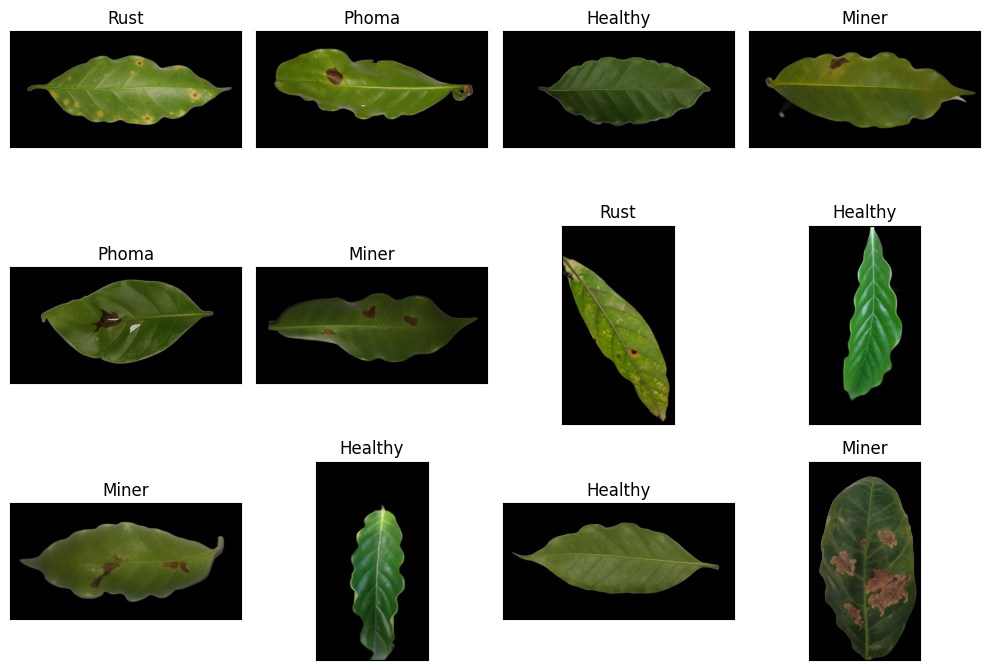

In [45]:
# Display some pictures of the dataset with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

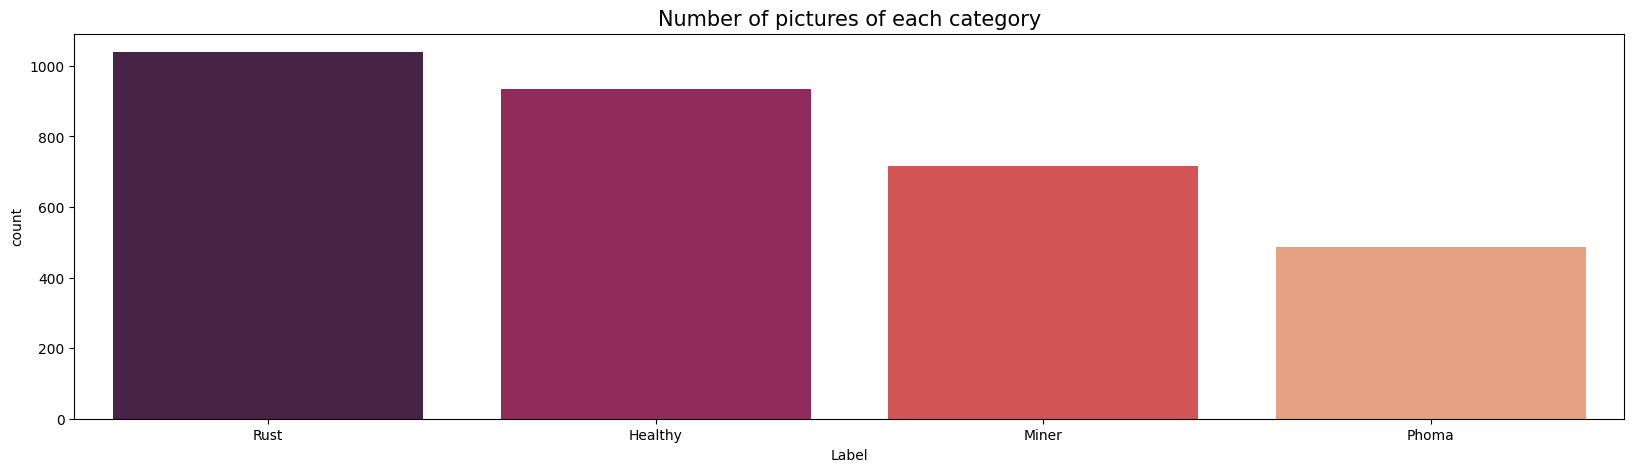

In [46]:

# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [47]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [48]:
#data generator
# !pip install tensorflow
import tensorflow as tf #Import tensorflow

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( # Use tf.keras.preprocessing.image.ImageDataGenerator
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Use tf.keras.preprocessing.image.ImageDataGenerator

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2541 validated image filenames belonging to 4 classes.
Found 636 validated image filenames belonging to 4 classes.


# Built Inception

In [49]:
# Download the pre-trained weights for ResNet101V2. No top means it excludes the fully connected layer.
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-06 13:22:25--  https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 74.125.141.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171317808 (163M) [application/octet-stream]
Saving to: '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/resnet101v2_we 100%[===================>] 163.38M   190MB/s    in 0.9s    

2024-10-06 13:22:26 (190 MB/s) - '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [171317808/171317808]



In [50]:
from keras import Model, Input
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

In [51]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'


# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = ResNet101V2(input_shape = (224, 224, 3),
                                include_top = False,
                                input_tensor=model_input,
                                weights = "imagenet")

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [52]:
pre_trained_model.summary()

Model: "resnet101v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,626,560 (162.61 MB)

In [53]:
# Choose `conv5_block1_1_conv` as the last layer of your base model
last_layer = pre_trained_model.get_layer('conv4_block6_out')
print('last layer output shape: ', last_layer.output.shape) # Use output.shape instead of output_shape
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 1024)


In [54]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)

# Append the dense network to the base model
resnet101v2 = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
resnet101v2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 9,100,292 (34.71 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 8,573,440 (32.71 MB)

In [55]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('val_accuracy')>=0.9999):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
callbacks = EarlyStoppingAtMaxAccuracy()

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
checkpoint_path = '/kaggle/working/resnet101v2.keras'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan

In [57]:

# # Set the training parameters
# callbacks= myCallback()
resnet101v2.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [58]:
history_resnet101v2 = resnet101v2.fit(
                  train_data,
                  batch_size=32,
                  validation_data=validasi_data,
                  epochs=30, callbacks=([callbacks],[checkpoint_callback]))

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.3335 - loss: 1.3770
Epoch 1: val_loss improved from inf to 1.19848, saving model to /kaggle/working/resnet101v2.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 86s 893ms/step - accuracy: 0.3340 - loss: 1.3761 - val_accuracy: 0.4780 - val_loss: 1.1985
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.4393 - loss: 1.2044
Epoch 2: val_loss improved from 1.19848 to 1.10617, saving model to /kaggle/working/resnet101v2.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 817ms/step - accuracy: 0.4392 - loss: 1.2042 - val_accuracy: 0.5739 - val_loss: 1.1062
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.4933 - loss: 1.1278
Epoch 3: val_loss improved from 1.10617 to 1.09098, saving model to /kaggle/working/resnet101v2.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 822ms/step - accuracy: 0.4935 - loss: 1.1276 - val_accuracy: 0.5299 - val_loss: 1.0910
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.5437 - loss: 1.0658
Epoch 4: va

# Saved Model to .h5

In [59]:
MODEL_BASE_PATH = "/kaggle/working/model/"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "resnet15epoch.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
resnet101v2.save(save_model_path,include_optimizer=False)

Saving Model At /kaggle/working/model/H5/resnet15epoch.h5...


In [60]:
resnet101v2.evaluate(validasi_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.7510 - loss: 0.6613


[0.675376296043396, 0.7374213933944702]

# Plotting Accuration After Training and Test Model

In [61]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(6,8), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

/tmp/ipykernel_30/4112711871.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


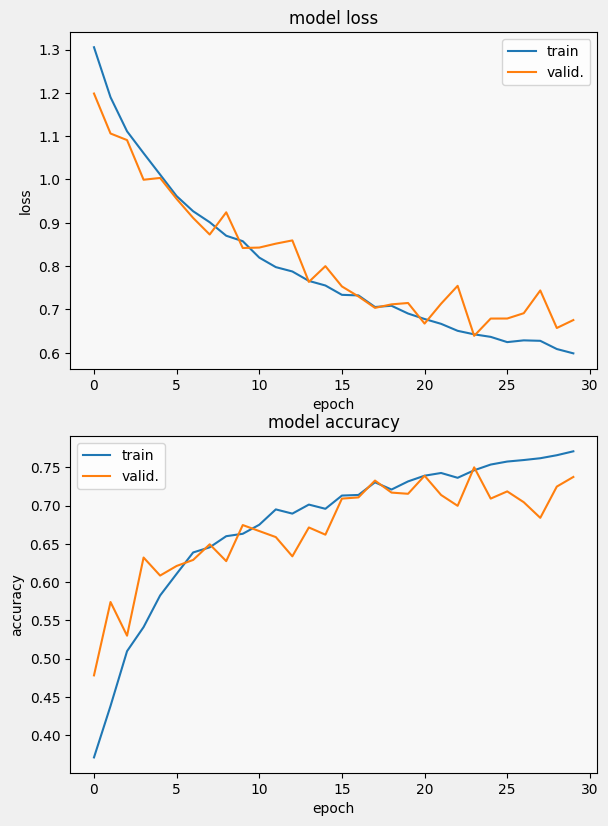

In [62]:
#display
display_training_curves(
    history_resnet101v2.history['loss'],
    history_resnet101v2.history['val_loss'],
    'loss', 211)
display_training_curves(
    history_resnet101v2.history['accuracy'],
    history_resnet101v2.history['val_accuracy'],
    'accuracy', 212)

In [63]:
# Predict the label of the test_images
import numpy as np
pred = resnet101v2.predict(validasi_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:4]}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step
The first 5 predictions: ['Healthy', 'Healthy', 'Healthy', 'Miner']


In [64]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(validasi_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Healthy       0.73      0.76      0.74       185
       Miner       0.70      0.85      0.77       138
       Phoma       0.60      0.99      0.75        90
        Rust       0.95      0.55      0.70       223

    accuracy                           0.74       636
   macro avg       0.75      0.79      0.74       636
weighted avg       0.78      0.74      0.73       636



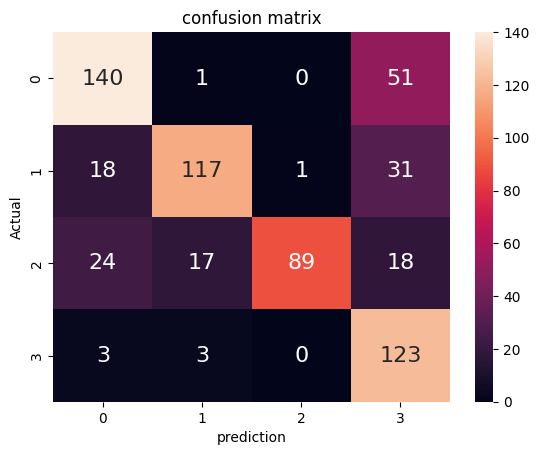

In [65]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

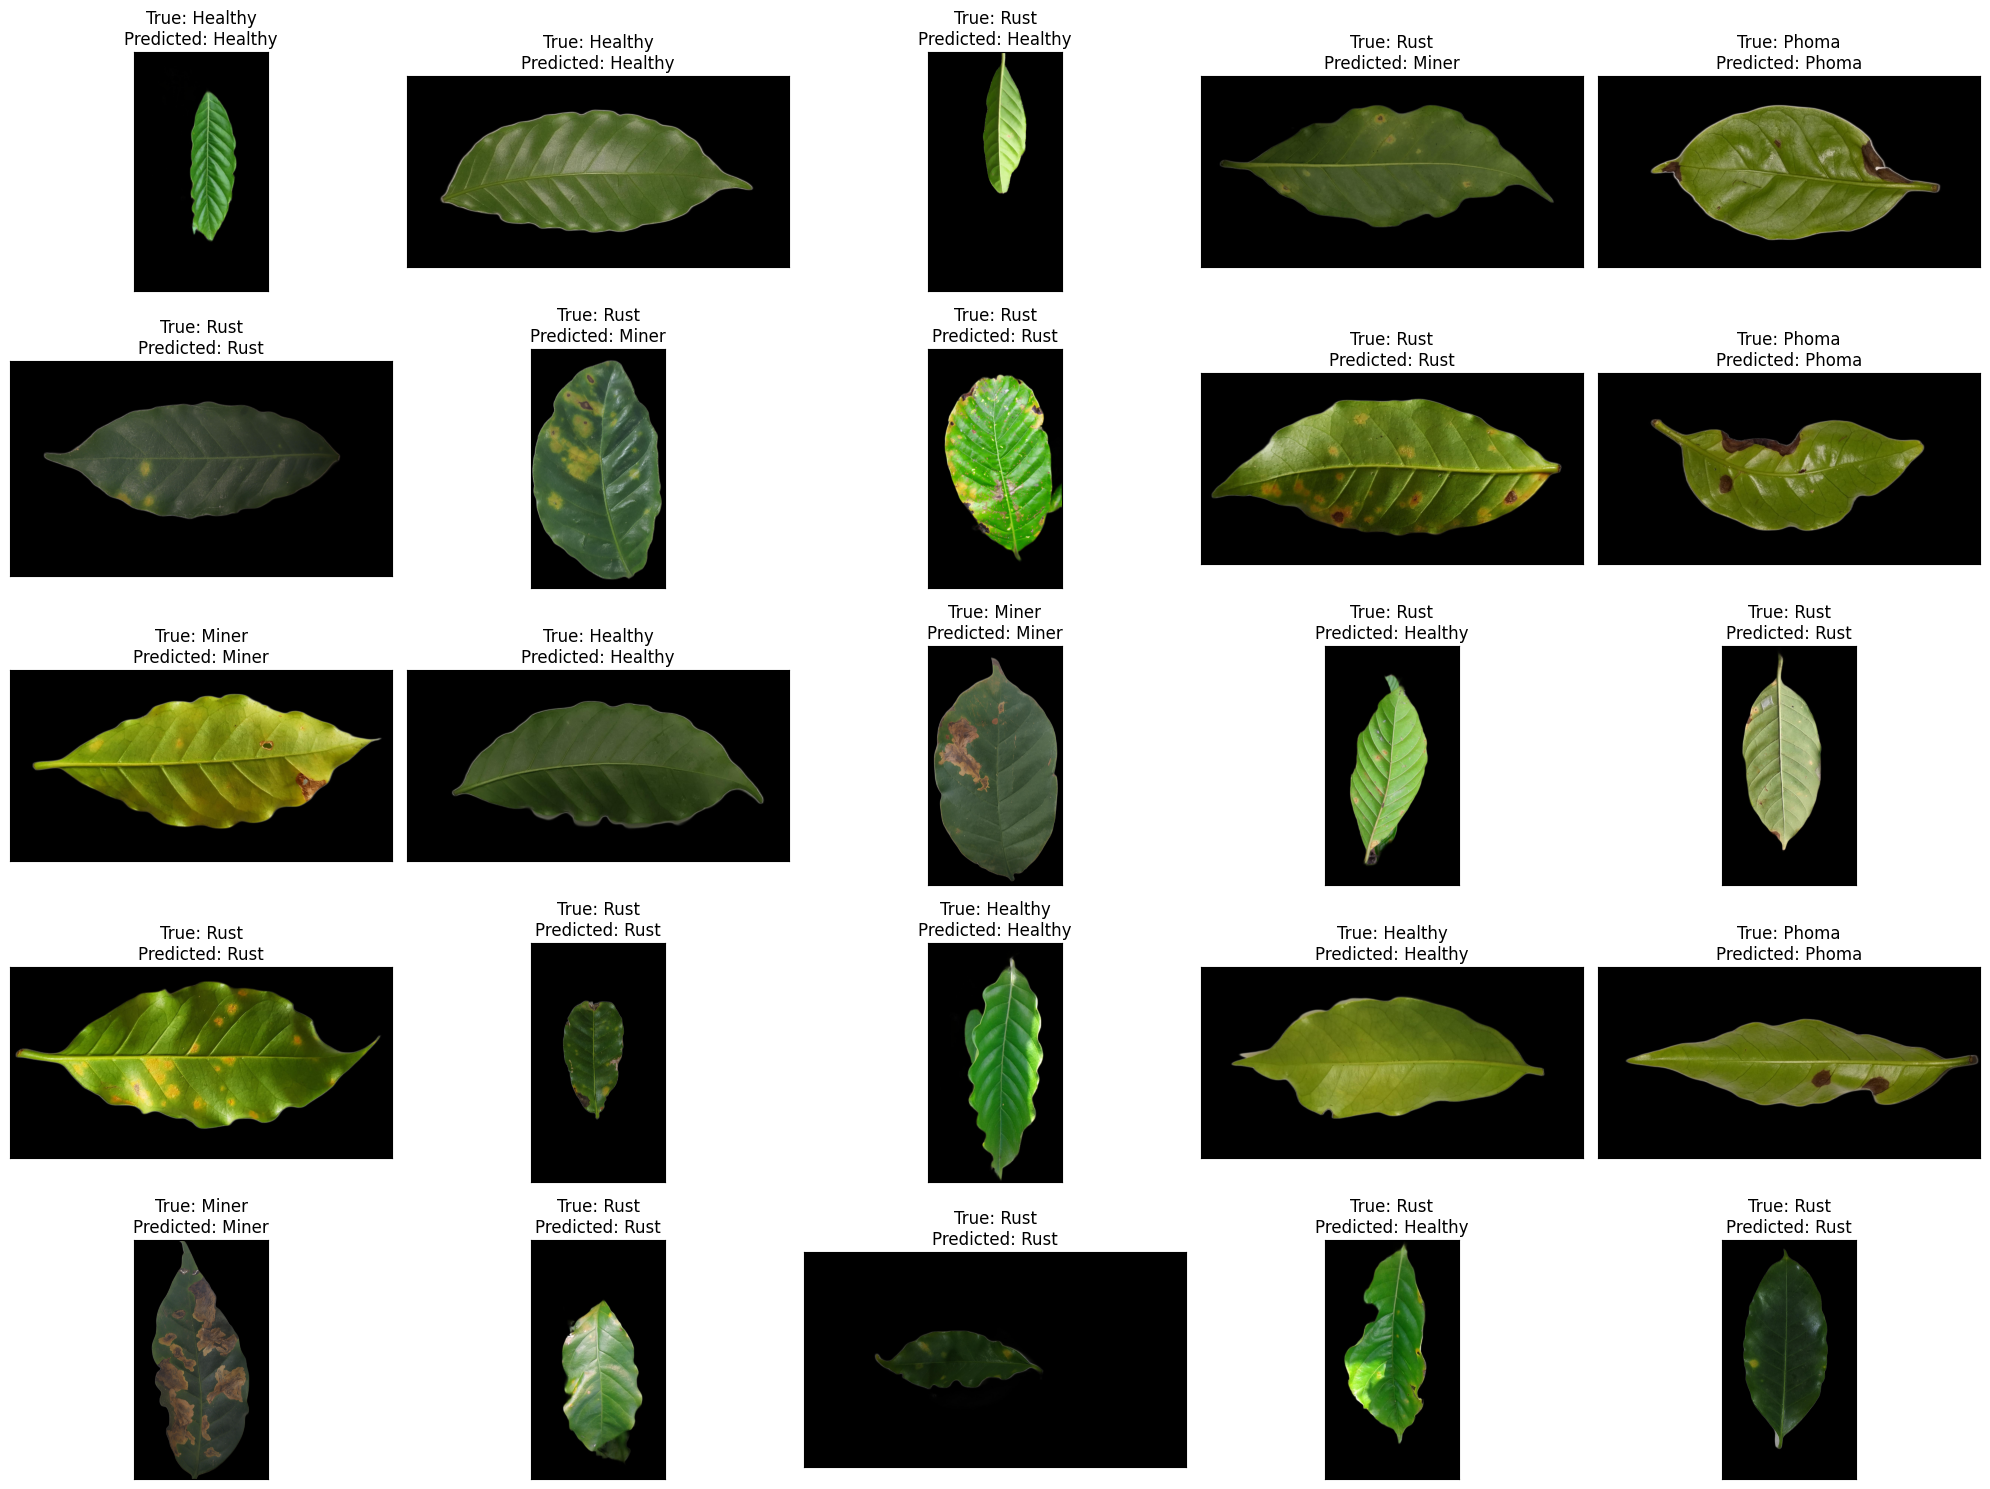

In [66]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()